In [1]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

df = pd.read_csv(os.path.join(path, os.listdir(path)[0]), header=0, index_col=0, parse_dates=True)
df.head()

/Users/notagain/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [2]:
airpasslog = np.log(df) #Logarithmic transformation

airpasslog_1 = airpasslog.diff().dropna() #Simple differencing

airpasslog_2 = airpasslog_1.diff(periods = 12).dropna() #Order 12 differencing

A SARIMA model is written as  SARIMA(𝑝,𝑑,𝑞)(𝑃,𝐷,𝑄)𝑘
 

The terms  𝑑
  and  𝐷
  correspond to the degrees of differencing used to make the time series stationary.

The second parenthesis containing uppercase terms corresponds to the seasonal part of the  SARIMA
  and  𝑘
  indicates the seasonality used.

Thus the  SARIMA
  process combines both simple and seasonal differencing with a simple  ARMA
  process and a seasonal  ARMA
  process.

In our exercise, we identified a seasonality of period 12 ( 𝑘=12
 ). Additionally, we did a simple differencing ( 𝑑=1
 ) and a seasonal differencing ( 𝐷=1
 ) to make our time series stationary.

Therefore our model will be of the form  SARIMA(𝑝,1,𝑞)(𝑃,1,𝑄)12
 . We then need to choose the right orders  𝑝
 ,  𝑞
 ,  𝑃
  and  𝑄
  for our ARMA processes.

b) Orders of AR(p) or MA(q) Models
To determine the orders of an  AR
  or  MA
  process, we can again rely on its autocorrelation diagrams (or autocorrelograms).

Instead of pandas we will use here the statsmodels library which also allows us to visualize the partial autocorrelation of a time series.

Reminders:

Autocorrelation is the degree of similarity between the values of the series and its time-lagged values. In other words, it measures the correlation between the series and itself with a given "lag". For example, autocorrelation with a lag of 1 indicates the degree of dependence between each value of the series and the previous value. This can help identify repetitive patterns, such as cycles or seasonal trends.

Partial autocorrelation measures the correlation between a value in the series and a value lagged by several periods while controlling for the influence of intermediate lags. For example, partial autocorrelation with a lag of 2 measures the relationship between a value and the value two periods before, eliminating the influence of lag 1. This allows detection of specific lag effects without being "polluted" by correlations due to intermediate lags.

Mathematically, for a time series following an  AR(𝑝)
  process, its simple autocorrelation (ACF) decreases towards 0, and its partial autocorrelation (PACF) becomes zero after rank  𝑝
 .

For a time series following an  MA(𝑞)
  process, its simple autocorrelation (ACF) becomes zero after rank  𝑞
  and its partial autocorrelation (PACF) decreases towards 0.



However, for  ARMA(𝑝,𝑞)
  processes, the distinction is not as clear and both simple and partial autocorrelations tend towards 0.

See rules for visually determining p and q orders:

AR(p)	MA(q)	ARMA(p,q)
ACF	Tends to 0	Becomes zero after order q	Tends to 0
PACF	Becomes zero after order p	Tends to 0	Tends to 0
To plot the simple and partial autocorrelograms of our time series, we will use the plot_acf and plot_pacf functions from the statsmodels.graphics.tsaplots submodule. They take as argument the series to study and with lags the number of lags to study

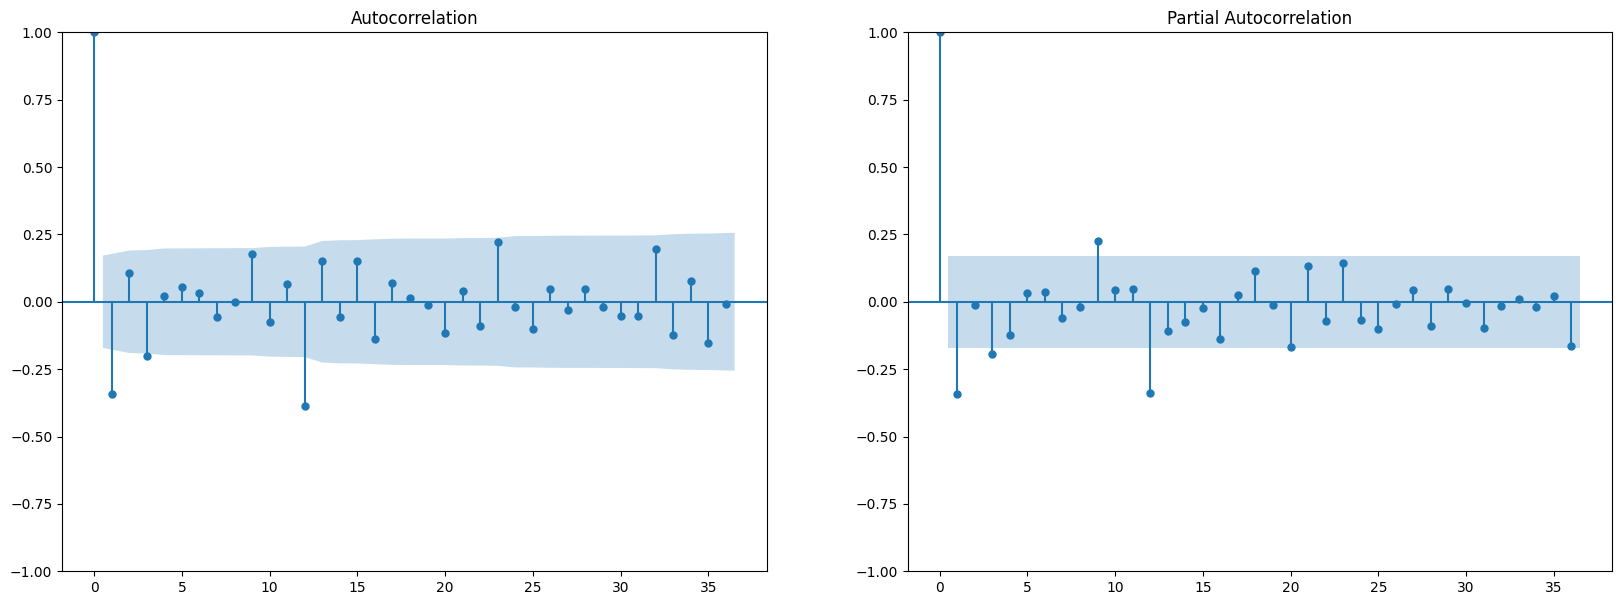

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(airpasslog_2, lags = 36, ax=ax1)
plot_pacf(airpasslog_2, lags = 36, ax=ax2)
plt.show()

The blue zone corresponds to a 95% confidence interval around the zero line. This means that if an autocorrelation or partial autocorrelation value falls outside this zone, it suggests that the value is statistically significant (i.e., it is unlikely to be due to chance).

Conversely, if the bar is within the blue zone, this indicates that the correlation is likely due to chance and is not significant. This will tell us that the value for this time lag has no impact on the value at time t.

We notice that the first peak has a value of 1, indeed it corresponds to zero lag, i.e., the correlation between time t and itself, and thus serves as a scale for the rest of the autocorrelogram.

We notice that both simple and partial autocorrelation tend to 0 (except for seasonal peaks). However, there doesn't seem to be a clear cutoff in the ACF and PACF diagrams. We can therefore assume an  ARMA(𝑝,𝑞)
  process. Since we don't have a clear way to choose the orders p and q, we will start by estimating the non-seasonal part of our time series via an  ARMA(1,1)
  model. If the model is not performant enough, we can increase these orders later.

For seasonal orders ( 𝑃
  and  𝑄
 ), we just need to refer to the same rules but looking only at seasonal peaks (n times the period). Here we therefore look at the  12𝑡ℎ
 ,  24𝑡ℎ
 , and  36𝑡ℎ
  peaks.

For simple autocorrelation, we observe a strong value at the  12𝑡ℎ
  peak, while the  24𝑡ℎ
  and  36𝑡ℎ
  peaks are in the blue zone, indicating they are not significant. Thus the ACF rule for an  MA(1)
  process is respected for seasonal terms.

For partial autocorrelation, the  12𝑡ℎ
  peak is still significant. The  24𝑡ℎ
  and  36𝑡ℎ
  peaks are at the limit of the non-significance zone. There is no clear cutoff but rather a decrease. As the  24𝑡ℎ
  and  36𝑡ℎ
  peaks are ambiguous, we will start with the simplest model by choosing an  AR(1)
  process for seasonal terms.

Thus we can assume an  ARMA(0,1)
  model for the seasonal part.

So for the orders  𝑝
 ,  𝑞
 ,  𝑃
 , and  𝑄
  we have:

A decrease in ACF and PACF without clear cutoff:  ARMA(1,1)
  model, (we take  𝑝=𝑞=1
  to start but it's possible to add terms if the model doesn't seem performant enough).

For seasonal peaks (12, 24, 36), an ACF cutoff after the first period and a PACF decrease:  MA(1)
  model

We will therefore train a  SARIMA(1,1,1)(0,1,1)12
  model.

In [5]:
model=sm.tsa.SARIMAX(airpasslog,order=(1,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

/Users/notagain/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/notagain/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66723D+00    |proj g|=  5.17008D+00

At iterate    5    f= -1.68391D+00    |proj g|=  2.34800D-01

At iterate   10    f= -1.68998D+00    |proj g|=  2.45871D+00

At iterate   15    f= -1.69397D+00    |proj g|=  4.30193D-01

At iterate   20    f= -1.69422D+00    |proj g|=  2.48079D-02

At iterate   25    f= -1.69453D+00    |proj g|=  3.07833D-02

At iterate   30    f= -1.69965D+00    |proj g|=  2.59941D-02

At iterate   35    f= -1.70102D+00    |proj g|=  3.07002D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [6]:
model = sm.tsa.SARIMAX(airpasslog,order=(0,1,1),seasonal_order=(0,1,1,12))
sarima=model.fit()
print(sarima.summary())

/Users/notagain/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/notagain/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66903D+00    |proj g|=  5.46246D+00

At iterate    5    f= -1.68810D+00    |proj g|=  1.63838D-01

At iterate   10    f= -1.69357D+00    |proj g|=  2.83790D+00

At iterate   15    f= -1.69921D+00    |proj g|=  7.76305D-03

At iterate   20    f= -1.69926D+00    |proj g|=  5.47174D-02

At iterate   25    f= -1.69928D+00    |proj g|=  5.54726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     51      1     0     0   

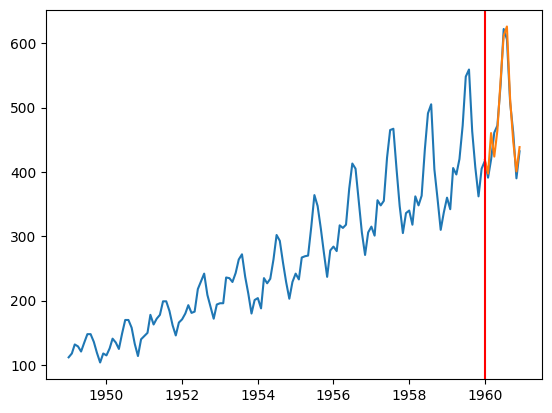

In [8]:
import datetime
pred = np.exp(sarima.predict(132, 143))#Prediction and conversion to exponential

airpasspred = pd.concat([df, pred])#Concatenation of predictions

plt.plot(airpasspred) #Visualization

plt.axvline(x= datetime.date(1960,1,1), color='red');

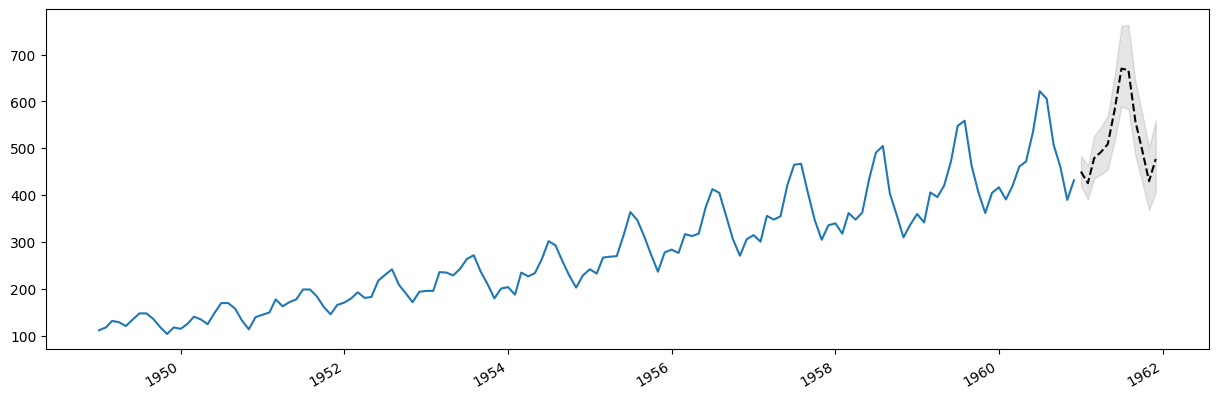

In [9]:
prediction = sarima.get_forecast(steps=12).summary_frame()  #Prediction with confidence interval

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df)
prediction = np.exp(prediction) #Converting to exponential

prediction['mean'].plot(ax=ax, style='k--') #Visualizing the mean

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Visualizing the confidence interval